Владелец фермы хочет купить бурёнок, чтобы расширить поголовье стада коров. Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. Нужно разработать модель машинного обучения, которая поможет владельцу фермы управлять рисками и принимать объективное решение о покупке.

**Цели:** нужно создать две прогнозные модели для отбора бурёнок в поголовье

1. Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.



В нашем распоряжении 3 датасета.

* ferma_main.csv, где

id — уникальный идентификатор коровы.

Удой, кг — масса молока, которую корова даёт в год (в килограммах).

ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.

Сырой протеин, г — содержание сырого протеина в корме (в граммах).

СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.

Порода — порода коровы.

Тип пастбища — ландшафт лугов, на которых паслась корова.

порода папы_быка — порода папы коровы.

Жирность,% — содержание жиров в молоке (в процентах).

Белок,% — содержание белков в молоке (в процентах).

Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).

Возраст — возраст коровы, бинарный признак (менее 2 лет, более 2 лет).

* ferma_dad.csv, где

id — уникальный идентификатор коровы.

Имя Папы — имя папы коровы.

* cow_buy.csv, где

Порода — порода коровы.

Тип пастбища — ландшафт лугов, на которых паслась корова.

порода папы_быка — порода папы коровы.

Имя_папы — имя папы коровы.

Текущая_жирность,% — содержание жиров в молоке (в процентах).

Текущий_уровень_белок,% — содержание белков в молоке (в процентах).

Возраст — возраст коровы, бинарный признак (менее 2 лет, более 2 лет).

In [ ]:
!pip install scikit-learn==1.5.0

In [2]:
#подключаем библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as st
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
plt.rcParams["figure.figsize"] = (12,10)

## Загрузка данных

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
display(ferma_main, ferma_dad, cow_buy)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
629,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


In [4]:
#сразу посмотрим на информацию о датасетах 
print(ferma_main.info())
print(ferma_main.describe())
print(ferma_main.duplicated().sum())
print(ferma_main.isna().sum())
ferma_main.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

(634, 12)

In [5]:
display(ferma_main.info(), ferma_main.describe(), ferma_main.duplicated().sum(), ferma_main.isna().sum(), ferma_main.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,14.542744,1922.682965,0.912855,3.603943,3.075666
std,183.096982,1638.401021,1.301301,182.392548,0.032209,0.168020,0.002540
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,159.250000,5751.750000,13.500000,1772.250000,0.890000,3.590000,3.074000
50%,317.500000,6130.500000,14.700000,1880.500000,0.930000,3.650000,3.076000
75%,475.750000,6501.000000,15.600000,2058.750000,0.940000,3.720000,3.077000
max,629.000000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


5

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

(634, 12)

In [6]:
print(ferma_dad.info())
print(ferma_dad.describe())
print(ferma_dad.duplicated().sum())
print(ferma_dad.isna().sum())
ferma_dad.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None
              id
count  629.00000
mean   315.00000
std    181.72094
min      1.00000
25%    158.00000
50%    315.00000
75%    472.00000
max    629.00000
0
id          0
Имя Папы    0
dtype: int64


(629, 2)

In [7]:
print(cow_buy.info())
print(cow_buy.describe())
print(cow_buy.duplicated().sum())
print(cow_buy.isna().sum())
cow_buy.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None
       Текущая_жирность,%  Текущий_уровень_белок,%
count           20.000000                20.000000
mean             3.577500                 3.069500
std              0.126818                 0.010339
min              3.340000                 3.046000
25%              3.510000                 3.064000
50%              3.590000                 3.07400

(20, 7)

**ferma_main** - имеется 5 явных дубликатов, необходимо привести названия столбцов к единому виду, в остальном всё в порядке.

**ferma_dad** - необходимо привести названия столбцов к единому виду, в остальном всё в порядке.

**cow_buy** - имеется 4 явных дубликата, необходимо привести названия столбцов к единому виду, в остальном всё в порядке.

##  Предобработка данных

In [8]:
#приведем столбцы к единству
ferma_main.rename(columns={'Удой, кг': 'удой', 'ЭКЕ (Энергетическая кормовая единица)': 'эке', 'Сырой протеин, г': 'сырой_протеин', 'СПО (Сахаро-протеиновое соотношение)': 'спо', 'Порода': 'порода', 'Тип пастбища': 'тип_пастбища', 'порода папы_быка': 'порода_папы_быка', 'Жирность,%': 'жирность', 'Белок,%': 'белок', 'Вкус молока': 'вкус_молока', 'Возраст': 'возраст',}, inplace=True)
ferma_main

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
629,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [9]:
ferma_dad.rename(columns={'Имя Папы': 'имя_папы'}, inplace=True)
ferma_dad.head()

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [10]:
cow_buy.rename(columns={'Порода': 'порода', 
                        'Тип пастбища': 'тип_пастбища', 
                        'порода папы_быка': 'порода_папы_быка', 
                        'Имя_папы': 'имя_папы', 'Текущая_жирность,%': 'текущая_жирность', 
                        'Текущий_уровень_белок,%': 'текущий_белок', 
                        'Возраст': 'возраст',}, inplace=True)
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


**ferma_main**

In [11]:
#поработаем с дубликатами
ferma_main[ferma_main.duplicated()]

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


Целых 5 строк, идущих по порядку

In [12]:
#удалим эти строки
ferma_main = ferma_main.drop_duplicates()
#проверим
ferma_main.duplicated().sum()

0

In [13]:
#посмотрим на неявные дубликаты
print(ferma_main['порода'].unique())
print(ferma_main['тип_пастбища'].unique())
print(ferma_main['порода_папы_быка'].unique())
print(ferma_main['вкус_молока'].unique())
print(ferma_main['возраст'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


Видим в столбцах *тип пастбища* и *порода папы быка* имеются неявные дубликаты

In [14]:
#заменим их
ferma_main['тип_пастбища'].replace({'Равнинные': 'Равнинное'}, inplace=True)
ferma_main['порода_папы_быка'].replace({'Айдиалл': 'Айдиал'}, inplace=True)
print(ferma_main['тип_пастбища'].unique())
print(ferma_main['порода_папы_быка'].unique())

['Равнинное' 'Холмистое']
['Айдиал' 'Соверин']


/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


**ferma_dad**

In [15]:
ferma_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Здесь все в порядке

**cow_buy**

In [16]:
cow_buy[cow_buy.duplicated()]

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_белок,возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [17]:
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


In [18]:
cow_buy['тип_пастбища'].replace({'холмистое': 'Холмистое', 'равнинное': 'Равнинное'}, inplace=True)

In [19]:
print(cow_buy['порода'].unique())
print(cow_buy['тип_пастбища'].unique())
print(cow_buy['порода_папы_быка'].unique())
print(cow_buy['имя_папы'].unique())
print(cow_buy['возраст'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Холмистое' 'Равнинное']
['Айдиал' 'Соверин']
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
['более_2_лет' 'менее_2_лет']


### Вывод по блоку предобработки данных:

Столбцы в датасетах были приведены к единому виду, были обработаны явные и неявные дубликаты. В целом исходные датасеты в "хорошем" состоянии.

## Исследовательский анализ данных

**Задачи:**
    
- Проведите статистический анализ всех признаков.
- Постройте графики для каждого признака. Помните, что количественным и категориальным признакам подходят разные графики.
- Сделайте выводы о данных:
напишите, заметили ли вы выбросы, необычное распределение количественных признаков или другие особенности;
расскажите, как вы планируете улучшить данные.

*Разделимся на категориальные и количественные признаки*

**КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ**

***Порода, тип пастбища, порода папы быка, вкус молока, возраст***

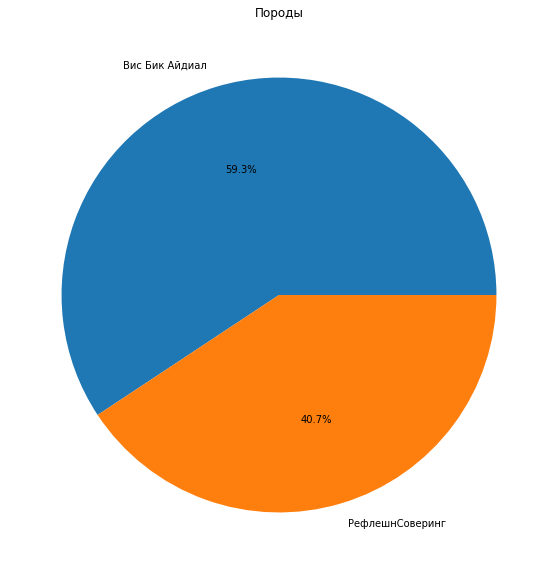

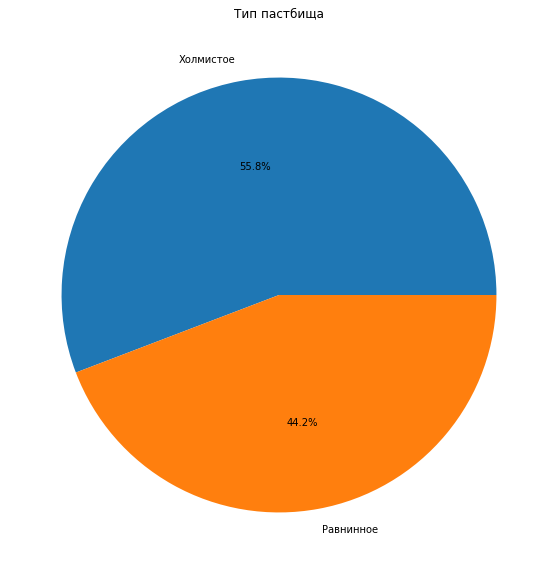

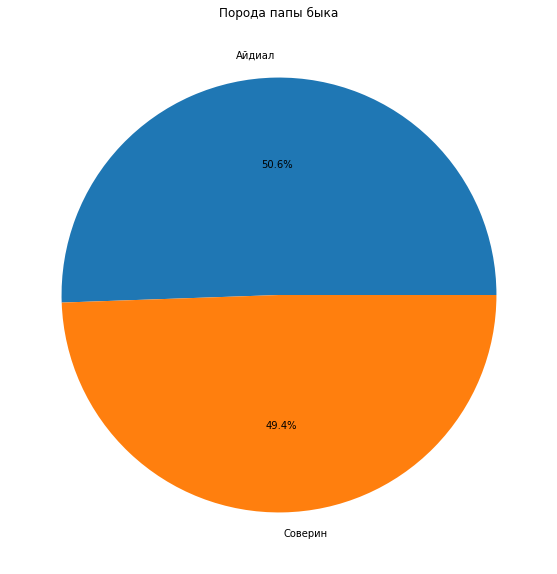

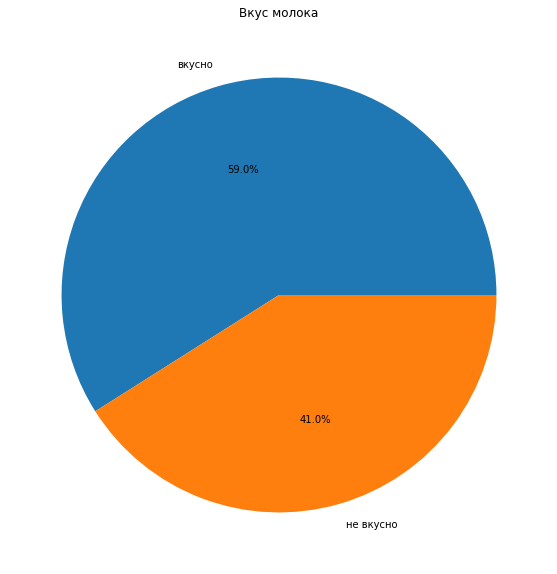

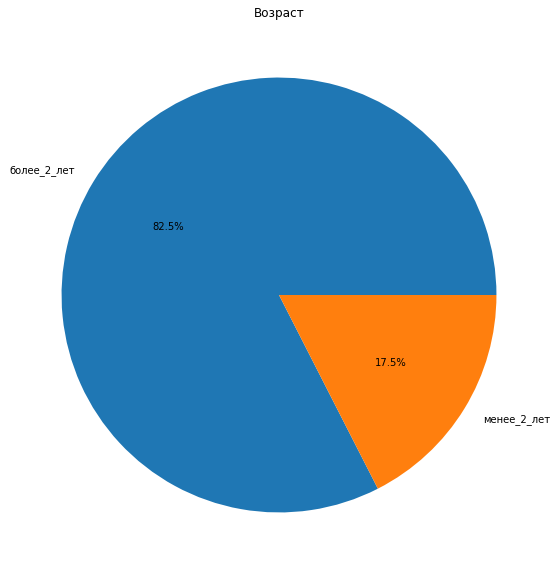

In [20]:
plt.pie(ferma_main['порода'].value_counts(), labels=['Вис Бик Айдиал ', 'РефлешнСоверинг'], autopct='%1.1f%%')
plt.title('Породы')
plt.grid()
plt.show()

plt.pie(ferma_main['тип_пастбища'].value_counts(), labels=['Холмистое', 'Равнинное'], autopct='%1.1f%%')
plt.title('Тип пастбища')
plt.show()

plt.pie(ferma_main['порода_папы_быка'].value_counts(), labels=['Айдиал', 'Соверин'], autopct='%1.1f%%')
plt.title('Порода папы быка')
plt.grid()
plt.show()

plt.pie(ferma_main['вкус_молока'].value_counts(), labels=['вкусно', 'не вкусно'], autopct='%1.1f%%')
plt.title('Вкус молока')
plt.grid()
plt.show()

plt.pie(ferma_main['возраст'].value_counts(), labels=['более_2_лет', 'менее_2_лет'], autopct='%1.1f%%')
plt.title('Возраст')
plt.grid()
plt.show()

**КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ**

***Удой, эке, сырой протеин, спо, жирность, белок***

In [21]:
ferma_main['удой'].sort_values(ascending=False)

16     45616
70      7222
135     7207
296     7201
294     7197
       ...  
578     5235
322     5215
589     5213
397     5207
273     5204
Name: удой, Length: 629, dtype: int64

Есть аномальное значение в "лице" *45616*, что это за корова с выработкой 45 тонн в год? Явно выброс. Избавимся. 

P.S. еще в блоке "Загрузка данных" было замечено это значение через describe() в колонке с максимальным значением.

In [22]:
ferma_main = ferma_main.query('удой != 45616')

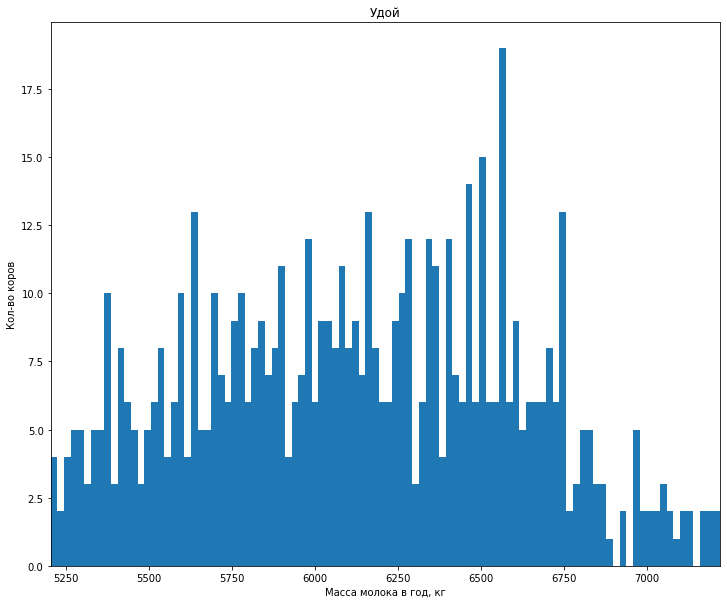

In [23]:
plt.hist(ferma_main['удой'], bins=100)
plt.xlim(5204, 7222)
plt.title('Удой')
plt.xlabel('Масса молока в год, кг')
plt.ylabel('Кол-во коров')
plt.show()

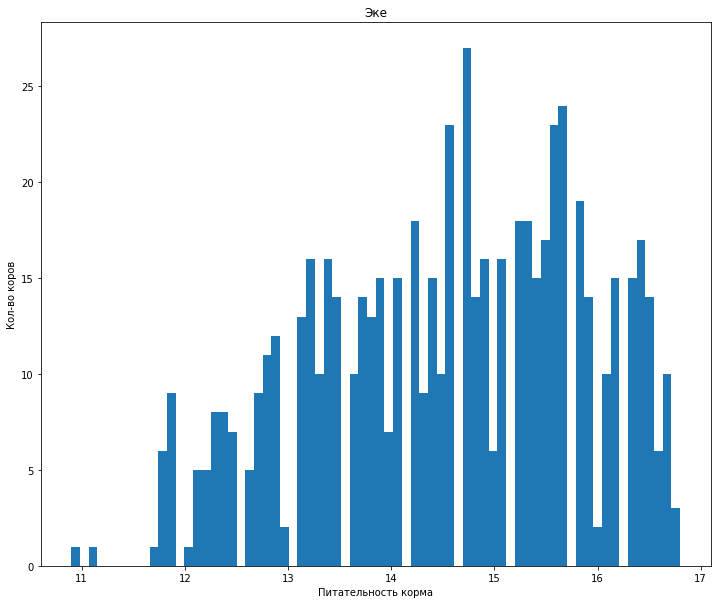

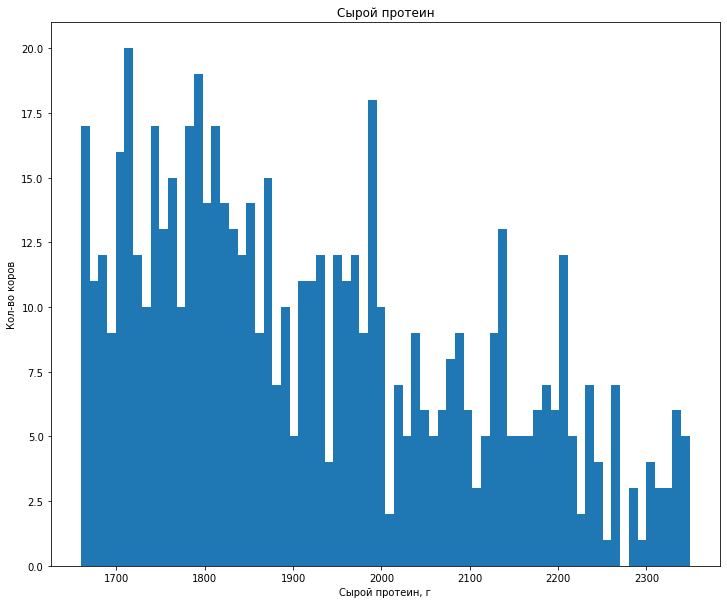

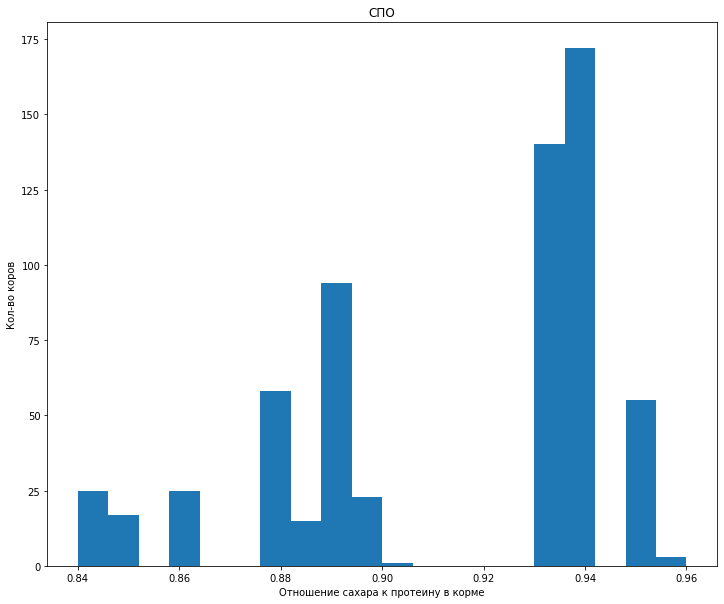

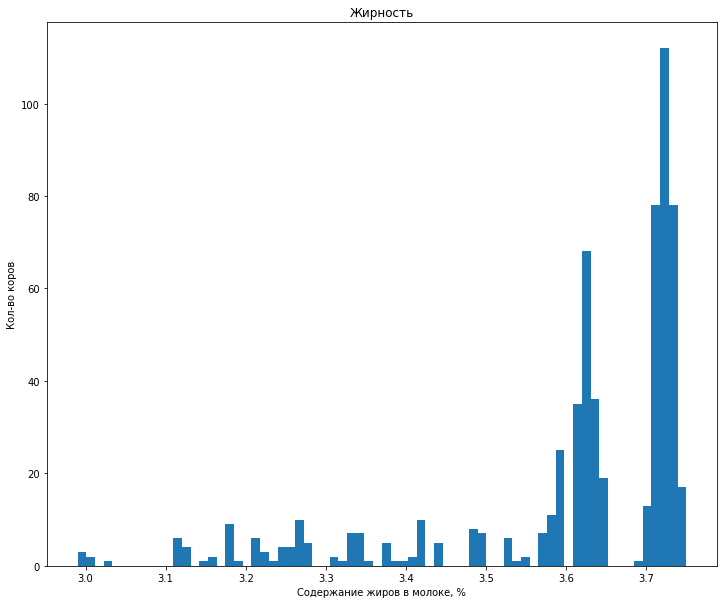

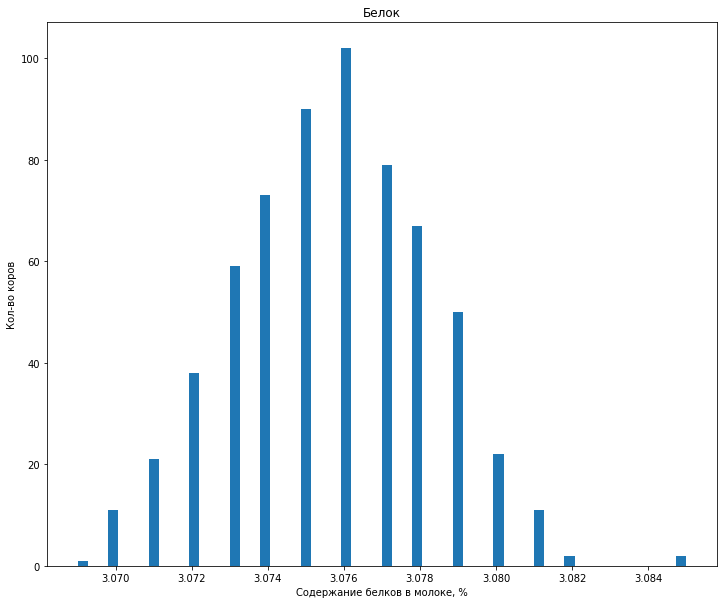

In [24]:
plt.hist(ferma_main['эке'], bins=70)
plt.title('Эке')
plt.xlabel('Питательность корма')
plt.ylabel('Кол-во коров')
plt.show()

plt.hist(ferma_main['сырой_протеин'], bins=70)
plt.title('Сырой протеин')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Кол-во коров')
plt.show()

plt.hist(ferma_main['спо'], bins=20)
plt.title('СПО')
plt.xlabel('Отношение сахара к протеину в корме')
plt.ylabel('Кол-во коров')
plt.show()

plt.hist(ferma_main['жирность'], bins=70)
plt.title('Жирность')
plt.xlabel('Cодержание жиров в молоке, %')
plt.ylabel('Кол-во коров')
plt.show()

plt.hist(ferma_main['белок'], bins=60)
plt.title('Белок')
plt.xlabel('Cодержание белков в молоке, %')
plt.ylabel('Кол-во коров')
plt.show()

### Вывод по блоку исследовательского анализа данных:

Особых корректировок не проводилось, кроме отличительного выброса в признаке *удой*. Признаки в целом распределены нормально. Оставим данные в покое.

## Корреляционный анализ

**Задачи:**
- Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками.

- Постройте диаграммы рассеяния scatterplot для признака Удой и всех количественных признаков с учётом значения категориальных признаков. Пример: диаграмма рассеяния для Удой и Сырой протеин цвет точек диаграммы отображает признак Порода. Учитывайте, что виды связи в подгруппах могут различаться — например, для разных пород.

- Сделайте выводы о взаимосвязи признаков.
Какой тип взаимосвязи между целевым и входными признаками?
Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?
Наблюдается ли мультиколлинеарность между входными признаками?

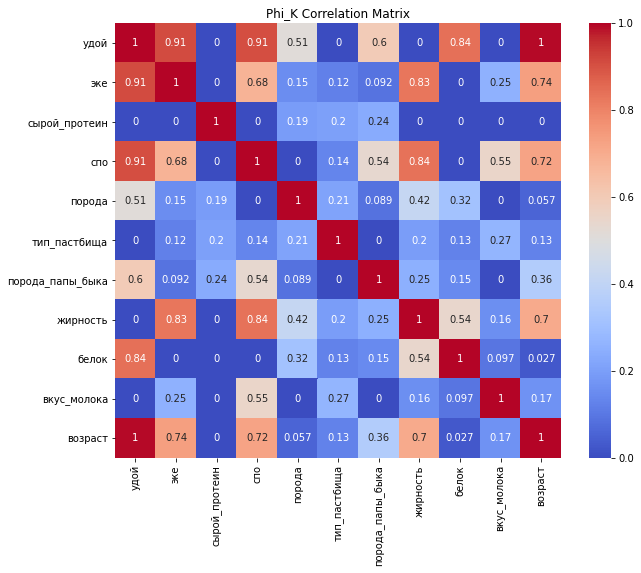

In [26]:
# Установим "руками", если не установлена
!pip install phik -q

# Импортируем
import phik

ferma_1 = ferma_main.drop('id', axis=1)

# Вычисление матрицы корреляции с использованием phik
corr_matrix = ferma_1.phik_matrix(interval_cols= 'удой')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

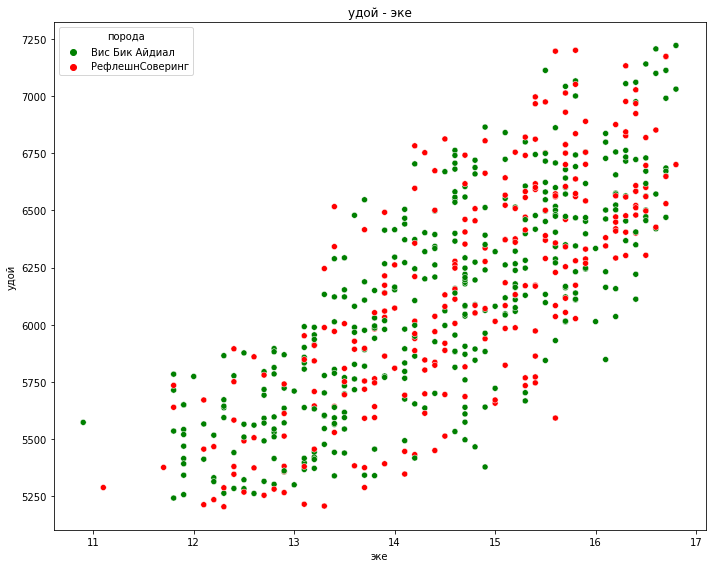

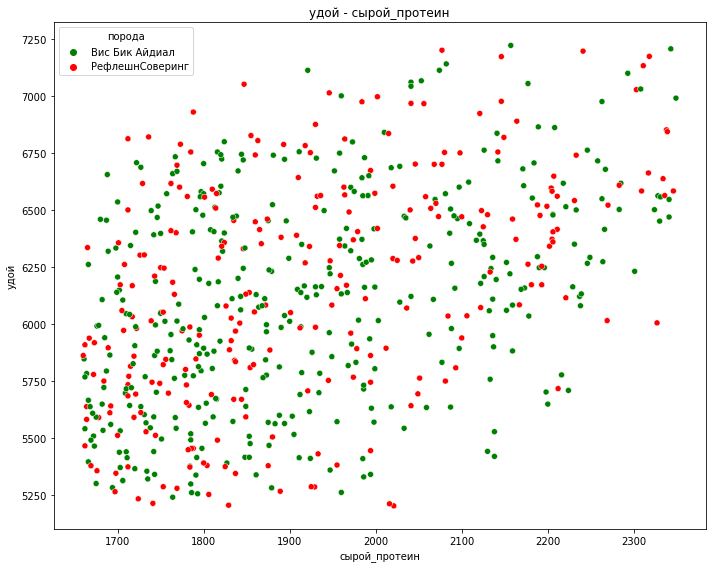

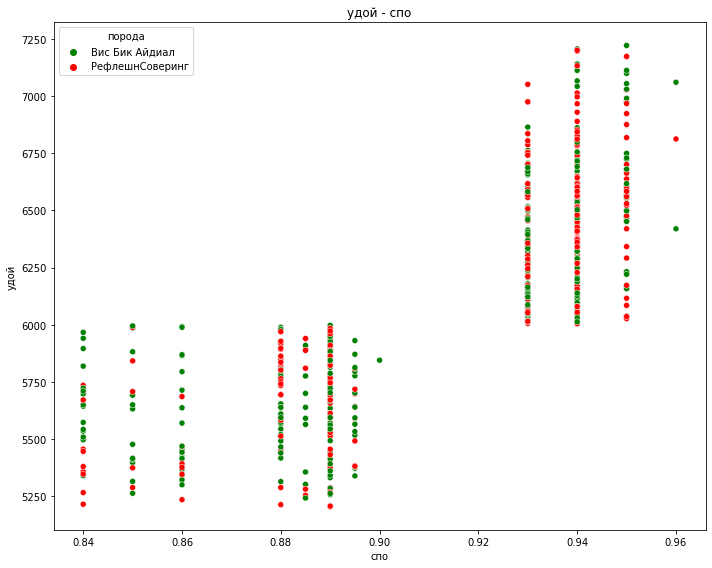

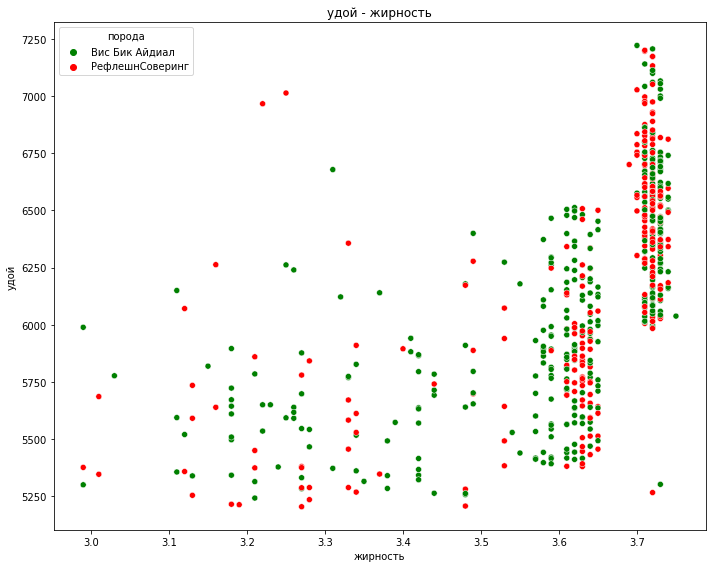

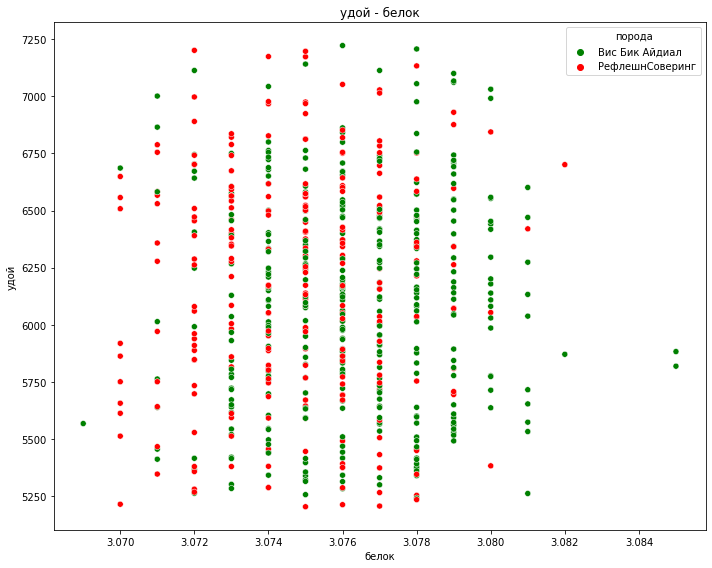

In [27]:
#построим диаграммы рассеивания
plt.figure(figsize=(10, 8))
sns.scatterplot(data=ferma_main, x='эке', y='удой', hue='порода', palette=['green', 'red'])
plt.title('удой - эке')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=ferma_main, x='сырой_протеин', y='удой', hue='порода', palette=['green', 'red'])
plt.title('удой - сырой_протеин')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=ferma_main, x='спо', y='удой', hue='порода', palette=['green', 'red'])
plt.title('удой - спо')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=ferma_main, x='жирность', y='удой', hue='порода', palette=['green', 'red'])
plt.title('удой - жирность')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=ferma_main, x='белок', y='удой', hue='порода', palette=['green', 'red'])
plt.title('удой - белок')
plt.tight_layout()
plt.show()

### Вывод по блоку корреляционного анализа данных:

Как стало ясно, целевой признак у нас *удой*. Изучили взаимосвязи между признаками, а именно с *эке, сырой протеин, спо, жирность, белок*, и вот что выяснили:
- с *эке* видим положительную взаимосвязь, коэффициент взаимосвязи 0.77, с увеличением удоя увеличивается и эке.
- с *сырой протеин* видим разброс, коэффициент взаимосвязи 0.45
- с *спо* заметна сильная зависимость, об этом и говорит коэффициент взаимосвязи равный 0.81
- с *жирность* положительная зависимость, коэффициент взаимосвязи 0.6, связь лучше заметна при жирности равной 3.6 и 3.7.
- с *белок* наблюдается больше зависимость от породы (с увеличением белка увеличивается преобладание породы Вис Бик Айдиал), коэффициент взаимосвязи 0.

Между целевым и входными признаками связь в целом линейная. Нелинейные связи возможны у отдельных пород. 

Признаков мультиколлинеарности не обнаружено. 

## Обучение модели линейной регрессии

**Задачи:**
    
- Построить и обучить 3 модели линейной регрессии;
- Сравнить качество 3-х моделей;
- Оценить качество каждой модели по метрикам;
- С помощью лучшей модели спрогнозируйте коров, которых фермер хочет купить.

***МОДЕЛЬ 1***

"Избавимся" от признаков *белок*, *жирность* и *id*, так как: белок - взаимосвязь отсутствует, жирность - это больше к молоку, id - это номер.

In [28]:
#убираем признаки
ferma_main_lr1 = ferma_main.drop(['id', 'белок', 'жирность'], axis=1)

In [29]:
RANDOM_STATE = 42

X = ferma_main_lr1.drop('удой', axis=1)
y = ferma_main_lr1['удой']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE,)
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
num_col_names = ['эке', 'спо', 'сырой_протеин']

#кодируем и масштабируем
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [30]:
#обучим модель
reg_1 = LinearRegression()
reg_1.fit(X_train, y_train)
predictions = reg_1.predict(X_test)
r2_1 = r2_score(y_test, predictions)
mse_1 = mean_squared_error(y_test, predictions)
rmse_1 = mean_squared_error(y_test, predictions, squared=False)
mae_1 = mean_absolute_error(y_test, predictions)
r2_1

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.7844078173416966

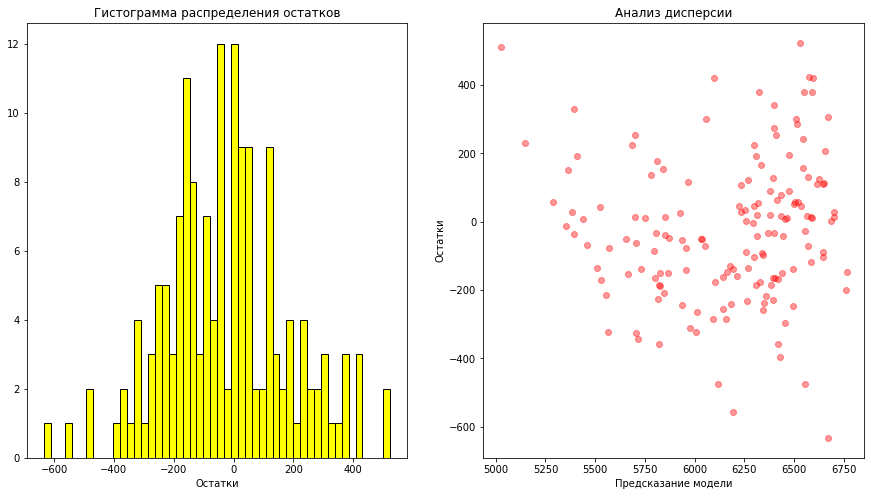

In [31]:
#остатки
residuals_1 = y_test - predictions

#гистограммa распределения
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
axes[0].hist(residuals_1, bins=50, color='yellow', edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

#график дисперсии
axes[1].scatter(predictions, residuals_1, color='red', alpha=0.4)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Выводы по первой модели:**

Остатки распределены в целом нормально, график гистрограммы даже почти симметричен. Модель хорошо предсказывает на участке по *удой* от 6250-6750, r2 =  0.7844078173416966

***МОДЕЛЬ 2***

In [32]:
ferma_main_lr2 = ferma_main

#преобразуем спо в категориальный признак
ferma_main_lr2['спо_кат'] = ferma_main_lr2['спо'].apply(lambda x: 1 if x > 0.91 else 0)

#преобразуем признак эке 
ferma_main_lr2['эке_квадрат'] = ferma_main_lr2['эке'] ** 2

#удалим ненужные признаки
ferma_main_lr2 = ferma_main.drop(['id', 'белок', 'жирность', 'эке', 'спо'], axis=1)
ferma_main_lr2

,удой,сырой_протеин,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст,спо_кат,эке_квадрат
0,5863,1743,Вис Бик Айдиал,Равнинное,Айдиал,вкусно,более_2_лет,0,201.64
1,5529,2138,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет,0,163.84
2,5810,1854,РефлешнСоверинг,Холмистое,Соверин,не вкусно,более_2_лет,0,196.00
3,5895,2012,РефлешнСоверинг,Холмистое,Айдиал,не вкусно,более_2_лет,0,153.76
4,5302,1675,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет,0,163.84
...,...,...,...,...,...,...,...,...,...
624,6812,1964,РефлешнСоверинг,Равнинное,Айдиал,не вкусно,более_2_лет,1,237.16
625,5513,1700,РефлешнСоверинг,Равнинное,Соверин,вкусно,менее_2_лет,0,166.41
626,5970,1837,РефлешнСоверинг,Холмистое,Соверин,не вкусно,более_2_лет,0,207.36
627,5746,1994,РефлешнСоверинг,Равнинное,Соверин,вкусно,более_2_лет,0,190.44


In [33]:
RANDOM_STATE = 42

X = ferma_main_lr2.drop('удой', axis=1)
y = ferma_main_lr2['удой']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка','возраст']
num_col_names = ['эке_квадрат', 'спо_кат', 'сырой_протеин']


#кодируем и масштабируем
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [34]:
#обучим модель
reg_2 = LinearRegression()
reg_2.fit(X_train, y_train)
predictions = reg_2.predict(X_test)
mse_2 = mean_squared_error(y_test, predictions)
rmse_2 = mean_squared_error(y_test, predictions, squared=False)
mae_2 = mean_absolute_error(y_test, predictions)
r2_2 = r2_score(y_test, predictions)
r2_2

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.81808799268675

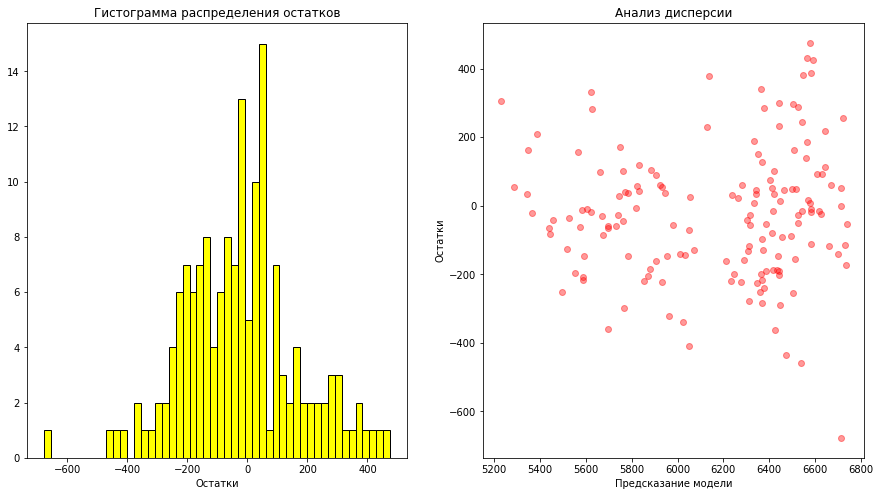

In [35]:
#остатки
residuals_2 = y_test - predictions

#гистограммa распределения
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
axes[0].hist(residuals_2, bins=50, color='yellow', edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

#график дисперсии
axes[1].scatter(predictions, residuals_2, color='red', alpha=0.4)
axes[1].set_xlabel('Предсказаниe модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Выводы по второй модели:**

Остатки распределены в целом нормально, график симметричен по самому частому значению. r2 =  0.81808799268675 (стало больше по сравнению с первой моделью)

***МОДЕЛЬ 3***

In [36]:
#добавим в данные признак имя_папы из файла ferma_dad
ferma_main_lr3 = ferma_main.merge(ferma_dad, on='id')

#преобразуем спо в категориальный признак
ferma_main_lr3['спо_кат'] = ferma_main_lr3['спо'].apply(lambda x: 1 if x > 0.91 else 0)

#преобразуем признак эке 
ferma_main_lr3['эке_квадрат'] = ferma_main_lr3['эке'] ** 2

#удалим ненужные признаки
ferma_main_lr3 = ferma_main_lr3.drop(['id', 'белок', 'жирность', 'эке', 'спо', 'вкус_молока'], axis=1)
ferma_main_lr3.head()

,удой,сырой_протеин,порода,тип_пастбища,порода_папы_быка,возраст,спо_кат,эке_квадрат,имя_папы
0,5863,1743,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,0,201.64,Буйный
1,5529,2138,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,0,163.84,Соловчик
2,5810,1854,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,0,196.00,Барин
3,5895,2012,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,0,153.76,Буйный
4,5302,1675,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,0,163.84,Барин


In [37]:
RANDOM_STATE = 42

X = ferma_main_lr3.drop('удой', axis=1)
y = ferma_main_lr3['удой']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)


cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
num_col_names = ['эке_квадрат', 'спо_кат', 'сырой_протеин']

#кодируем и масштабируем
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])


X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [38]:
#обучим модель
reg_3 = LinearRegression()
reg_3.fit(X_train, y_train)
predictions = reg_3.predict(X_test)
mse_3 = mean_squared_error(y_test, predictions)
rmse_3 = mean_squared_error(y_test, predictions, squared=False)
mae_3 = mean_absolute_error(y_test, predictions)
r2_3 = r2_score(y_test, predictions)
r2_3

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.8247542745210406

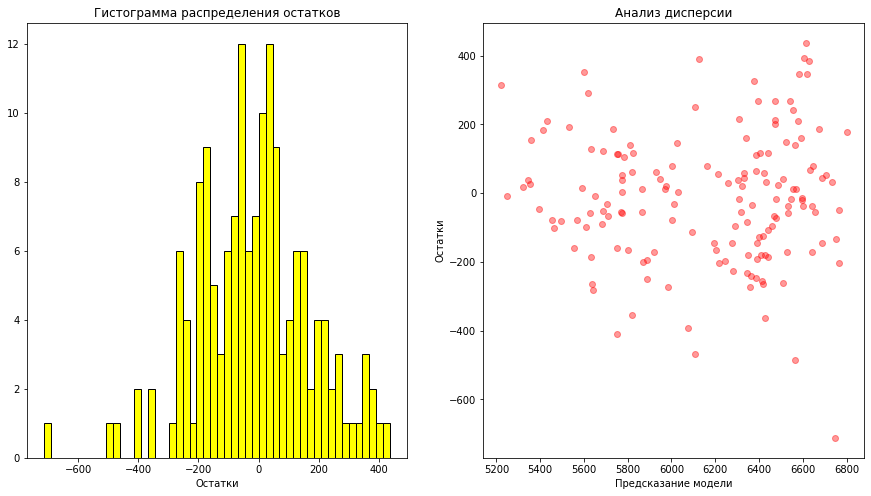

In [39]:
#остатки
residuals_3 = y_test - predictions

#гистограммa распределения
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
axes[0].hist(residuals_3, bins=50, color='yellow', edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

#график дисперсии
axes[1].scatter(predictions, residuals_3, color='red', alpha=0.4)
axes[1].set_xlabel('Предсказаниe модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Выводы по третьей модели:**

Остатки распределены в целом нормально, график симметричен по самому частому значению. r2 =  0.8247542745210406 (стало еще лучше)

***СРАВНИМ МОДЕЛИ по r2 и остаткам***

In [40]:
print(r2_1)
print(residuals_1.mean())
print('...')
print(r2_2)
print(residuals_2.mean())
print('...')
print(r2_3)
print(residuals_3.mean())

0.7844078173416966
-25.37328620820125
...
0.81808799268675
-24.372798135532403
...
0.8247542745210406
-15.201522000921376


По результатам обучения моделей, 3-я модель показала себя с "наилучшей стороны", а именно по значению r2 = 0.8247542745210406 и минимальному значению средних остатков равное -15.201522000921376.

***ОЦЕНИМ КАЧЕСТВО МОДЕЛЕЙ ПО МЕТРИКАМ MSE, MAE, RMSE***

In [41]:
print(mse_1)
print(rmse_1)
print(mae_1)
print('...')
print(mse_2)
print(rmse_2)
print(mae_2)
print('...')
print(mse_3)
print(rmse_3)
print(mae_3)

43887.01500966052
209.49227911706083
164.2419446347493
...
37030.91131113698
192.4341739690146
149.0396522236461
...
35673.88988618197
188.87532895055926
146.16302445362322


In [42]:
#посчитаем 95% доверительный интервал лучшей модели 
print(st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions)))

(6092.340075854288, 6221.3750700583805)


Всё же 3-я модель лучшая. Доверительный интервал лучшей модели (6092.340075854288, 6221.3750700583805). Ошибка в среднем на 146.16 кг.

***ПРОГНОЗ УДОЯ***

In [43]:
cow_buy_lr = cow_buy

#среднее значение каждого недостающего признака увеличим на 5%
mean_value = ferma_main[['эке', 'сырой_протеин', 'спо']].mean()
new_value = mean_value * 1.05

#добавим недостающие признаки в датасет cow_buy и преобразовываем их
cow_buy_lr['эке'] = new_value['эке']
cow_buy_lr['эке_квадрат'] = cow_buy_lr['эке'] ** 2
cow_buy_lr['сырой_протеин'] = new_value['сырой_протеин']
cow_buy_lr['спо'] = new_value['спо']
cow_buy_lr['спо_кат'] = cow_buy_lr['спо'].apply(lambda x: 1 if x > 0.91 else 0)

#удалим ненужные признаки
cow_buy_lr = cow_buy_lr.drop(['текущий_белок', 'эке', 'спо', 'текущая_жирность'], axis=1)
#проверим
display(cow_buy_lr.head())
display(cow_buy_lr.shape)

,порода,тип_пастбища,порода_папы_быка,имя_папы,возраст,эке_квадрат,сырой_протеин,спо_кат
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,более_2_лет,233.361138,2019.947532,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,менее_2_лет,233.361138,2019.947532,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,более_2_лет,233.361138,2019.947532,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,более_2_лет,233.361138,2019.947532,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,более_2_лет,233.361138,2019.947532,1


(20, 8)

In [44]:
ferma_main_lr3

,удой,сырой_протеин,порода,тип_пастбища,порода_папы_быка,возраст,спо_кат,эке_квадрат,имя_папы
0,5863,1743,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,0,201.64,Буйный
1,5529,2138,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,0,163.84,Соловчик
2,5810,1854,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,0,196.00,Барин
3,5895,2012,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,0,153.76,Буйный
4,5302,1675,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,0,163.84,Барин
...,...,...,...,...,...,...,...,...,...
623,6812,1964,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет,1,237.16,Буйный
624,5513,1700,РефлешнСоверинг,Равнинное,Соверин,менее_2_лет,0,166.41,Барин
625,5970,1837,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,0,207.36,Барин
626,5746,1994,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,0,190.44,Барин


In [45]:
cow_buy_lr = cow_buy_lr[['сырой_протеин', 
                         'порода', 
                         'тип_пастбища', 
                         'порода_папы_быка', 
                         'возраст', 'спо_кат', 
                         'эке_квадрат', 
                         'имя_папы']]
cow_buy_lr

,сырой_протеин,порода,тип_пастбища,порода_папы_быка,возраст,спо_кат,эке_квадрат,имя_папы
0,2019.947532,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,1,233.361138,Геркулес
1,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,1,233.361138,Буйный
2,2019.947532,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,1,233.361138,Барин
3,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,1,233.361138,Буйный
4,2019.947532,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет,1,233.361138,Буйный
5,2019.947532,РефлешнСоверинг,Равнинное,Соверин,менее_2_лет,1,233.361138,Геркулес
6,2019.947532,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,1,233.361138,Геркулес
7,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,более_2_лет,1,233.361138,Буйный
8,2019.947532,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,1,233.361138,Барин
9,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,менее_2_лет,1,233.361138,Буйный


In [47]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
num_col_names = ['эке_квадрат', 'спо_кат', 'сырой_протеин']

X_test_ohe = encoder.transform(cow_buy_lr[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

X_test_scaled = scaler.transform(cow_buy_lr[num_col_names])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_test_final = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [48]:
pred = reg_3.predict(X_test_final)
pred

array([6609.91929681, 6378.71102836, 6283.99977532, 6593.08937654,
       6542.14606633, 6425.38021759, 6609.91929681, 6571.25973712,
       6283.99977532, 6400.54066779, 6344.70785976, 6617.92892634,
       6609.91929681, 6127.4747423 , 6283.99977532, 6593.08937654,
       6344.70785976, 6425.38021759, 6571.25973712, 6542.14606633])

In [50]:
cow_buy['прогноз_удой'] = pred
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_белок,возраст,эке,эке_квадрат,сырой_протеин,спо,спо_кат,прогноз_удой
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6609.919297
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6378.711028
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6283.999775
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6593.089377
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6542.146066
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6425.380218
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6609.919297
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6571.259737
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6283.999775
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6400.540668


### Вывод по блоку обучения модели линейной регрессии:

- Отобрали лучшую модель для прогноза с показателями: MSE = 35362.015389658605, RMSE = 188.04790716638834, MAE = 144.71452607169232, доверительный интервал лучшей модели (6093.573683581589, 6222.856638026672). Ошибка в среднем на 144.71 кг;

- спрогнозирован удой по коровам из датасета;

- все коровы по прогнозу дадут 6000+ кг удоя.

## Обучение модели логистической регрессии

**Задачи:**
    
- Построить и обучить модель логистической регрессии;
- Проанализировать модель;
- С помощью обученной модели спрогнозируйте вкус молока коров, которых фермер хочет купить.

***ПОСТРОЕНИЕ И ОБУЧЕНИЕ МОДЕЛИ***

In [51]:
ferma_log = ferma_main

#редактирование признаков
ferma_log['вкус_молока_кат'] = ferma_log['вкус_молока'].apply(lambda x: 0 if x == 'вкусно' else 1)
ferma_log['спо_кат'] = ferma_log['спо'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_log['эке_квадрат'] = ferma_log['эке'] ** 2

ferma_log = ferma_log.drop(['id', 'удой', 'вкус_молока', 'эке', 'спо'], axis=1)

ferma_log.head()

,сырой_протеин,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,спо_кат,эке_квадрат,вкус_молока_кат
0,1743,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет,0,201.64,0
1,2138,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет,0,163.84,0
2,1854,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет,0,196.00,1
3,2012,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет,0,153.76,1
4,1675,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет,0,163.84,0


In [52]:
RANDOM_STATE = 42

X = ferma_log.drop('вкус_молока_кат', axis=1)
y = ferma_log['вкус_молока_кат']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y)

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат']
num_col_names = ['жирность', 'белок', 'эке_квадрат', 'сырой_протеин']

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [53]:
#обучим модель
clf = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf_accuracy = accuracy_score(y_pred, y_test)
clf_recall = recall_score(y_pred, y_test)
clf_precision = precision_score(y_pred, y_test)
print(clf_accuracy)
print(clf_recall)
print(clf_precision)

0.6305732484076433
0.5535714285714286
0.484375


accuracy = 0.5859872611464968

recall = 0.6285714285714286

precision = 0.717391304347826

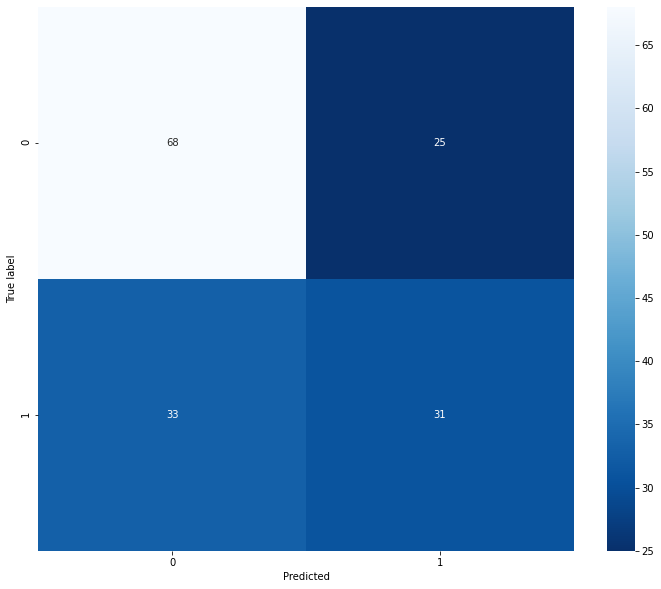

In [54]:
#матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Видим 39 ошибок первого рода, что является больше половины верных предсказаний. Будем минимизировать.

***АНАЛИЗ МОДЕЛИ***

Наша цель предложить фермеру коров с вкусным молоком. Для этого нам необходимо улучшить метрику Precision, то есть свести ошибки первого рода к минимуму.

Начнем с подбора порога класса.

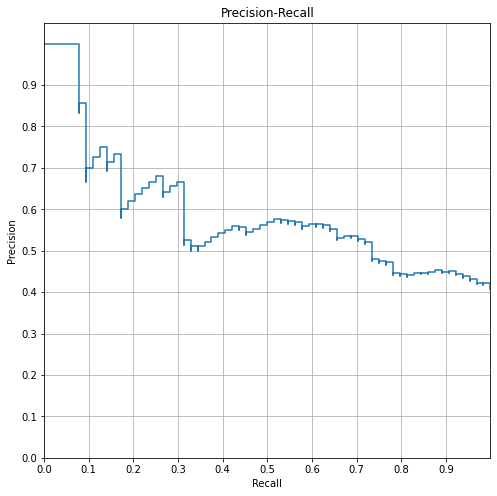

In [55]:
probabilities_test = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_test[:, 1])

plt.figure(figsize=(8, 8))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.grid()
plt.title('Precision-Recall')
plt.show()

In [56]:
#посмотрим на вероятности класса predict_proba() и правильные ответы
y_proba = clf.predict_proba(X_test)[:, 1]
proba_data = pd.DataFrame(zip(y_test, y_proba), columns=['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)
proba_data.head()

,y_test,y_proba
146,1,0.758778
119,1,0.730288
65,1,0.721133
142,1,0.719113
109,1,0.718297


In [57]:
#функция расчета метрик для каждого порога
def threshold_choice(threshold_list, proba_df):
    result_df = pd.DataFrame(columns=['порог', 'precision', 'recall', 'количество_FP', 'число_предсказанных_объектов', 'всего_объектов_класса_1'])

    for threshold in threshold_list:
        column_name = 'y_pred_' + str(threshold)

        #precision
        precision = proba_df.loc[proba_df[column_name] == 1, 'y_test'].mean()

        #предсказанные обьекты
        predicted_objects = proba_df[column_name].sum()

        #количество обьектов класса 1
        total_objects_class_1 = proba_df['y_test'].sum()

        #recall
        recall = proba_df.loc[(proba_df[column_name] == 1) & (proba_df['y_test'] == 1)].shape[
                     0] / total_objects_class_1

        #количество FP
        false_positives = proba_df.loc[(proba_df[column_name] == 1) & (proba_df['y_test'] == 0)].shape[0]

        #добавим результаты в датафрейм
        result_df = result_df.append({
            'порог': threshold,
            'precision': precision,
            'recall': recall,
            'количество_FP': false_positives,
            'число_предсказанных_объектов': predicted_objects,
            'всего_объектов_класса_1': total_objects_class_1,
        }, ignore_index=True)

    return result_df

In [58]:
#перебор порогов
proba_data_1 = proba_data.copy(deep=True)
thresholds_1 = [round(i, 2) for i in np.linspace(0.1, 1, num=10, endpoint=False)]

columns = []

for i in thresholds_1:
    columns.append('y_pred_' + str(i))
    proba_data_1['y_pred_' + str(i)] = proba_data_1['y_proba'].apply(lambda x: 1 if x > i else 0)

proba_data_1.head()

,y_test,y_proba,y_pred_0.1,y_pred_0.19,y_pred_0.28,y_pred_0.37,y_pred_0.46,y_pred_0.55,y_pred_0.64,y_pred_0.73,y_pred_0.82,y_pred_0.91
146,1,0.758778,1,1,1,1,1,1,1,1,0,0
119,1,0.730288,1,1,1,1,1,1,1,1,0,0
65,1,0.721133,1,1,1,1,1,1,1,0,0,0
142,1,0.719113,1,1,1,1,1,1,1,0,0,0
109,1,0.718297,1,1,1,1,1,1,1,0,0,0


In [59]:
threshold_choice(thresholds_1, proba_data_1)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.10,0.407643,1.000000,93.0,157.0,64.0
1,0.19,0.421053,1.000000,88.0,152.0,64.0
2,0.28,0.448819,0.890625,70.0,127.0,64.0
3,0.37,0.475728,0.765625,54.0,103.0,64.0
4,0.46,0.557143,0.609375,31.0,70.0,64.0
5,0.55,0.555556,0.312500,16.0,36.0,64.0
6,0.64,0.714286,0.156250,4.0,14.0,64.0
7,0.73,1.000000,0.031250,0.0,2.0,64.0
8,0.82,NaN,0.000000,0.0,0.0,64.0
9,0.91,NaN,0.000000,0.0,0.0,64.0


 Есть предположение рассмотреть интервал 0.73-0.91 "поближе", так как количество FP до порога 0.73 и ниже идет на увеличение, а от 0.91 и выше наоборот.  

In [60]:
#перебор порогов
proba_data_2 = proba_data.copy(deep=True)

thresholds_2 = [round(i, 2) for i in np.linspace(0.73, 0.91, num=19, endpoint=False)]

columns = []

for i in thresholds_2:
    columns.append('y_pred_' + str(i))
    proba_data_2['y_pred_' + str(i)] = proba_data_2['y_proba'].apply(lambda x: 1 if x > i else 0)

proba_data_2.head(5)

,y_test,y_proba,y_pred_0.73,y_pred_0.74,y_pred_0.75,y_pred_0.76,y_pred_0.77,y_pred_0.78,y_pred_0.79,y_pred_0.8,y_pred_0.81,y_pred_0.82,y_pred_0.83,y_pred_0.84,y_pred_0.85,y_pred_0.86,y_pred_0.87,y_pred_0.88,y_pred_0.89,y_pred_0.9
146,1,0.758778,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
119,1,0.730288,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65,1,0.721133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
142,1,0.719113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
109,1,0.718297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
threshold_choice(thresholds_2, proba_data_2)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.73,1.0,0.031250,0.0,2.0,64.0
1,0.74,1.0,0.015625,0.0,1.0,64.0
2,0.75,1.0,0.015625,0.0,1.0,64.0
3,0.76,NaN,0.000000,0.0,0.0,64.0
4,0.77,NaN,0.000000,0.0,0.0,64.0
5,0.78,NaN,0.000000,0.0,0.0,64.0
6,0.79,NaN,0.000000,0.0,0.0,64.0
7,0.80,NaN,0.000000,0.0,0.0,64.0
8,0.81,NaN,0.000000,0.0,0.0,64.0
9,0.82,NaN,0.000000,0.0,0.0,64.0


Порог 0.81 - оптимальный. Количество FP снижено до 0.

In [62]:
#оптимальный порог
OPTIMAL_THRESHOLD = 0.81

#применяем порог
y_pred_threshold = (y_proba > OPTIMAL_THRESHOLD).astype(int)

clf_accuracy_new = accuracy_score(y_test, y_pred_threshold)
clf_recall_new = recall_score(y_test, y_pred_threshold)
clf_precision_new = precision_score(y_test, y_pred_threshold)

print(clf_accuracy)
print(clf_recall)
print(clf_precision)
print('...')
print(clf_accuracy_new)
print(clf_recall_new)
print(clf_precision_new)

0.6305732484076433
0.5535714285714286
0.484375
...
0.5923566878980892
0.0
0.0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy уменьшилась, Recall уменьшилась, Precision увеличилась (что нам и нужно было)

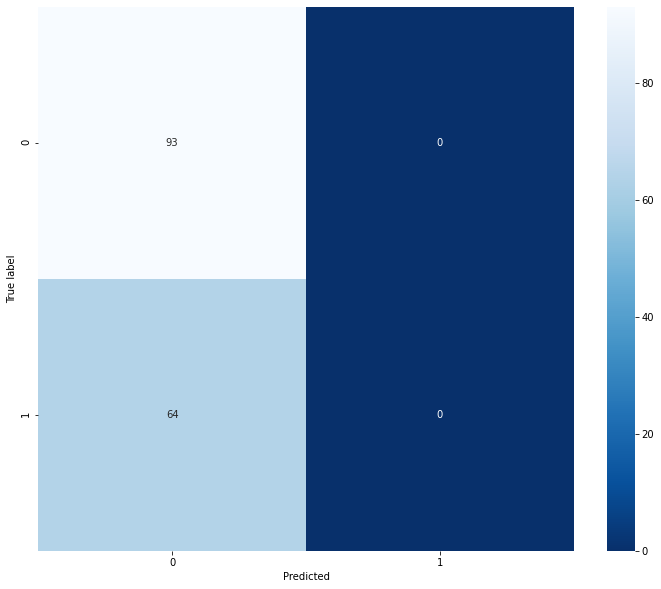

In [63]:
# Построение матрицы ошибок
cm_new = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Итак мы снизили количество FP до 0.

***ПРОГНОЗ ВКУСА МОЛОКА***

In [64]:
cow_buy_log_2 = cow_buy.copy(deep=True)

#добавим недостающие признаки в датасет cow_buy
cow_buy_log_2['эке'] = new_value['эке']
cow_buy_log_2['эке_квадрат'] = cow_buy_log_2['эке'] ** 2
cow_buy_log_2['сырой_протеин'] = new_value['сырой_протеин']
cow_buy_log_2['спо'] = new_value['спо']
cow_buy_log_2['спо_кат'] = cow_buy_log_2['спо'].apply(lambda x: 1 if x > 0.91 else 0)

#редактируем cow_buy
cow_buy_log_2.rename(columns={'текущая_жирность': 'жирность', 'текущий_белок': 'белок'}, inplace=True)
cow_buy_log_2 = cow_buy_log_2.drop(['имя_папы', 'эке', 'спо'], axis=1)
cow_buy_log_2.head()

,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,эке_квадрат,сырой_протеин,спо_кат,прогноз_удой
0,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,233.361138,2019.947532,1,6609.919297
1,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,233.361138,2019.947532,1,6378.711028
2,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,233.361138,2019.947532,1,6283.999775
3,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,233.361138,2019.947532,1,6593.089377
4,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,233.361138,2019.947532,1,6542.146066


In [65]:
cow_buy_log_2 = cow_buy_log_2[['сырой_протеин', 
                               'порода', 
                               'тип_пастбища', 
                               'порода_папы_быка', 
                               'жирность', 'белок', 
                               'возраст', 'спо_кат', 
                               'эке_квадрат']]
cow_buy_log_2.head()

,сырой_протеин,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,спо_кат,эке_квадрат
0,2019.947532,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,1,233.361138
1,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,1,233.361138
2,2019.947532,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,1,233.361138
3,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,1,233.361138
4,2019.947532,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,1,233.361138


In [66]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат']
num_col_names = ['жирность', 'белок', 'эке_квадрат', 'сырой_протеин']

X_test_ohe = encoder.transform(cow_buy_log_2[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

X_test_scaled = scaler.transform(cow_buy_log_2[num_col_names])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_test_final = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [67]:
predictions_final = (clf.predict_proba(X_test_final)[:, 1]).astype(int)
predictions_final

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [68]:
cow_buy['прогноз_вкус'] = predictions_final
cow_buy['прогноз_вкус'] = cow_buy['прогноз_вкус'].map({1: 'вкусно', 0: 'не вкусно'}).astype(str)
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_белок,возраст,эке,эке_квадрат,сырой_протеин,спо,спо_кат,прогноз_удой,прогноз_вкус
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6609.919297,не вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6378.711028,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6283.999775,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6593.089377,не вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6542.146066,не вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6425.380218,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6609.919297,не вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6571.259737,не вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6283.999775,не вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6400.540668,не вкусно


## Итоговые выводы

Нами были изучены 3 датасета, в которых содержались данные о стаде фермера, имя папы каждой коровы в стаде фермера и данные о коровах "ЭкоФермы".

1. В предобработке данных столбцы в датасетах были приведены к единому виду, были обработаны явные и неявные дубликаты. В целом исходные датасеты были в "хорошем" состоянии.


2. Что мы выяснили из исследовательского анализа данных: особых корректировок не проводилось, кроме отличительного выброса в признаке *удой*. Признаки в целом распределены нормально.


3. По корреляционному анализу данных: 
- как стало ясно, целевой признак у нас *удой*. Изучили взаимосвязи между признаками, а именно с *эке, сырой протеин, спо, жирность, белок*, и вот что выяснили:
- с *эке* видим положительную взаимосвязь, коэффициент взаимосвязи 0.91, с увеличением удоя увеличивается и эке.
- с *сырой протеин* видим разброс, коэффициент взаимосвязи 0.
- с *спо* заметна сильная зависимость, об этом и говорит коэффициент взаимосвязи равный 0.91
- с *жирность* коэффициент взаимосвязи 0, связь лучше заметна при жирности равной 3.6 и 3.7.
- с *белок* наблюдается больше зависимость от породы (с увеличением белка увеличивается преобладание породы Вис Бик Айдиал), коэффициент взаимосвязи 0.84.
- c *порода* 0.51.
- с *тип пастбища* 0.
- с *порода папы быка* 0.6.
- с *вкус молока* 0.
- с *возраст* 1.
- между целевым и входными признаками связь в целом линейная. Нелинейные связи возможны у отдельных пород. 
- признаков мультиколлинеарности не обнаружено. 


4. По задачам построения моделей линейной регрессии: 
- построили и обучили 3 модели линейной регрессии и рассмотрелии остатки
- отобрали лучшую модель для прогноза с показателями: MSE = 35673.88988618197, RMSE = 188.87532895055926, MAE = 146.16302445362322, доверительный интервал лучшей модели (6092.340075854288, 6221.3750700583805). Ошибка в среднем на 146.16 кг;
- спрогнозировали удой по коровам из датасета;
- все коровы по прогнозу дадут 6000+ кг удоя.
- добавили столбец с прогнозом удоя в таблицу продавца


5. По задачам классификации (прогноз вкуса молока):
- Подобрали параметры и обучили модель логистической регрессии
- Проанализировали модель и минимизировали количество критических ошибок первого рода с 39 до 0
- Определили, чье молоко предсказано как "вкусное"
- Учитывая оба условия заказчика, все коровы и по удою хороши и по вкусу молока идеальные.